In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
from torchvision.datasets.utils import download_url
import tarfile

In [3]:
# Dowload the dataset
dataset= "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset, '.')

In [4]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes) 

['train', 'labels.txt', 'test']
['deer', 'bird', 'automobile', 'truck', 'frog', 'cat', 'ship', 'airplane', 'horse', 'dog']


In [6]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['18694_airplane.png', '23776_airplane.png', '34693_airplane.png', '45594_airplane.png', '23096_airplane.png']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

img,label=dataset[0]


In [8]:
print('Dataset length :',len(dataset))

Dataset length : 50000


In [9]:
img.shape

torch.Size([3, 32, 32])

In [10]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


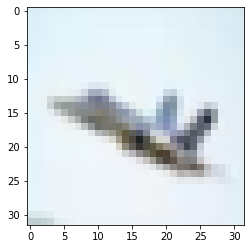

In [11]:
import matplotlib.pyplot as plt

#Rearranging the shape of image from 3*32*32 to 32*32*3 for showing image,using permute command

plt.imshow(img.permute(1,2,0))

## Splitting the dataset into training and validaton dataset

In [12]:
#A function for spliting the datasets randomly into training and validation

def split(n,per):
    n_p=int(n*per)
    np.random.seed(99)
    idx=np.random.permutation(n)
   
    return idx[n_p:],idx[:n_p]
    

train,valid=split(len(dataset),0.2)
print('Length of Train indices :',len(train))
print('Length of Validation indices :',len(valid))

Length of Train indices : 40000
Length of Validation indices : 10000


In [13]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size=100
#Traininfg sampler and loader
train_sampler=SubsetRandomSampler(train)
train_dl=DataLoader(dataset,batch_size,sampler=train_sampler)

#validation samppler and loader
valid_sampler=SubsetRandomSampler(valid)
valid_dl=DataLoader(dataset,batch_size,sampler=valid_sampler)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

simple_model=nn.Sequential(nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),nn.MaxPool2d(2,2))


In [15]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 8, 16, 16])


In [16]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 16 x 16
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 8 x 8

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 4 x 4
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 2 x 2

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 1 x 1,
    
    nn.Flatten(), # output: bs x 16
    nn.Linear(16, 10) # output: bs x 10 
)

In [17]:
for images,label in train_dl:
    out=model(images)
    break
    

prob=F.softmax(out[1],dim=0)
print(prob)
print('SUM of Probabilities',torch.sum(prob))
print('MAX of Probabilities',torch.max(prob))

tensor([0.1170, 0.0896, 0.1032, 0.0856, 0.0759, 0.1101, 0.0925, 0.0857, 0.1259,
        0.1146], grad_fn=<SoftmaxBackward>)
SUM of Probabilities tensor(1., grad_fn=<SumBackward0>)
MAX of Probabilities tensor(0.1259, grad_fn=<MaxBackward1>)


In [18]:
dataset.classes[label[2]]

'automobile'

## Train the Model

In [19]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Calculate loss
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [20]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric


In [21]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, 
        opt_fn=None, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    
    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Training
        model.train()
        for xb,yb in train_dl:
            train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Record the loss & metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], train_loss: {:4f}, val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss, 
                          metric.__name__, val_metric))
    return train_losses, val_losses, val_metrics

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [23]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3172, Accuracy: 0.0976


In [24]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.005

In [25]:
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)
train_losses, val_losses, val_metrics = history

Epoch [1/10], train_loss: 1.7127, val_loss: 1.6005, val_accuracy: 0.4160
Epoch [2/10], train_loss: 1.4319, val_loss: 1.4032, val_accuracy: 0.4871
Epoch [3/10], train_loss: 1.2569, val_loss: 1.3401, val_accuracy: 0.5122
Epoch [4/10], train_loss: 1.4639, val_loss: 1.3031, val_accuracy: 0.5284
Epoch [5/10], train_loss: 1.1925, val_loss: 1.2455, val_accuracy: 0.5475
Epoch [6/10], train_loss: 1.2343, val_loss: 1.2185, val_accuracy: 0.5608
Epoch [7/10], train_loss: 1.4426, val_loss: 1.2304, val_accuracy: 0.5551
Epoch [8/10], train_loss: 1.2568, val_loss: 1.1837, val_accuracy: 0.5714
Epoch [9/10], train_loss: 1.1517, val_loss: 1.1674, val_accuracy: 0.5778
Epoch [10/10], train_loss: 1.1288, val_loss: 1.2276, val_accuracy: 0.5610


In [26]:
def plot_metric(metric_values):
    """Plot metric values in a line graph"""
    plt.plot(metric_values, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

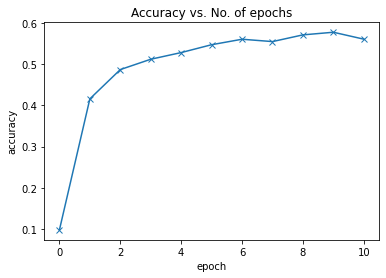

In [27]:
plot_metric([val_acc] + val_metrics)

In [31]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cpu')

In [40]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: bird


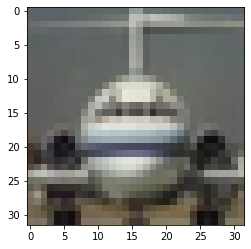

In [43]:
img, label = test_dataset[8]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))